In [4]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scienceplots
from tqdm import tqdm
import cmcrameri.cm as cmc
import cartopy.crs as ccrs
from scipy.stats import goodness_of_fit, norm, ks_1samp
from multiprocessing import Pool
plt.style.use(['science'])

from cycler import cycler
default_cycler = cycler('color', ['#CC6677', '#332288', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD'])

# Set custom colormap
plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

In [5]:
# data_path = Path(r"C:\Users\mathi\Danmarks Tekniske Universitet\Casper Tygesen Bang-Hansen - ProcessedGrids", "v6_mss21.nc")
# data_path = Path(r"C:\Users\mathi\Danmarks Tekniske Universitet\Casper Tygesen Bang-Hansen - ProcessedGrids", "without_polar_v6_mss21.nc")
# data_path = Path(r"C:\Users\mathi\Danmarks Tekniske Universitet\Casper Tygesen Bang-Hansen - ProcessedGrids", "south_africa_6thdeg_mss21.nc")
data_path = Path(r"C:\Users\mathi\Danmarks Tekniske Universitet\Casper Tygesen Bang-Hansen - ProcessedGrids", "south_africa_6thdeg_mss21_0_005td.nc")
# data_path = Path(r"C:\Users\mathi\Danmarks Tekniske Universitet\Casper Tygesen Bang-Hansen - ProcessedGrids", "CMEMS_south_china_sea.nc")
# data_path = Path(r"C:\Users\mathi\Danmarks Tekniske Universitet\Casper Tygesen Bang-Hansen - ProcessedGrids", "CMEMS.nc")
data = xr.load_dataset(data_path)

In [6]:
day = np.datetime64(f"1997-03-10T12:00:00.000000000")
# day = np.datetime64(f"2002-07-08T12:00:00.000000000")
# day = np.datetime64(f"2002-08-17T12:00:00.000000000")
bad_day = data.sla21.sel(time = (data.time >= day) & (data.time <= day+np.timedelta64(1)))[0]
vlim = 50

title_size = 20
label_size = 14
tick_size = 12
extent = [-180,180,-90,90]
n_axis_ticks = 7

fig = plt.figure(figsize=(10,3), dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
im=ax.imshow(bad_day*100, extent=extent, origin='lower', vmin=-vlim, vmax=vlim, cmap=cmc.vik)
ax.set_xlabel(f"Longitude [\N{DEGREE SIGN}]", fontsize=label_size)
ax.set_ylabel(f"Latitude [\N{DEGREE SIGN}]", fontsize=label_size)
ax.coastlines()
ax.set_extent(extent)
# ax.set_xticks([-180, -120, -60, 0, 60, 120, 180])
ax.set_xticks(np.linspace(extent[0],extent[1],n_axis_ticks))
# ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax.set_yticks(np.linspace(extent[2],extent[3],n_axis_ticks))
ax.tick_params(labelsize=tick_size)
cbar = fig.colorbar(im, ticks=range(-vlim,vlim+10,10))
cbar.set_label("SLA [cm]", fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)
title_day = str(day).split("T")[0]
# ax.set_title(f"Large irregularities at the Antarctic - {title_day}", fontsize=title_size)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

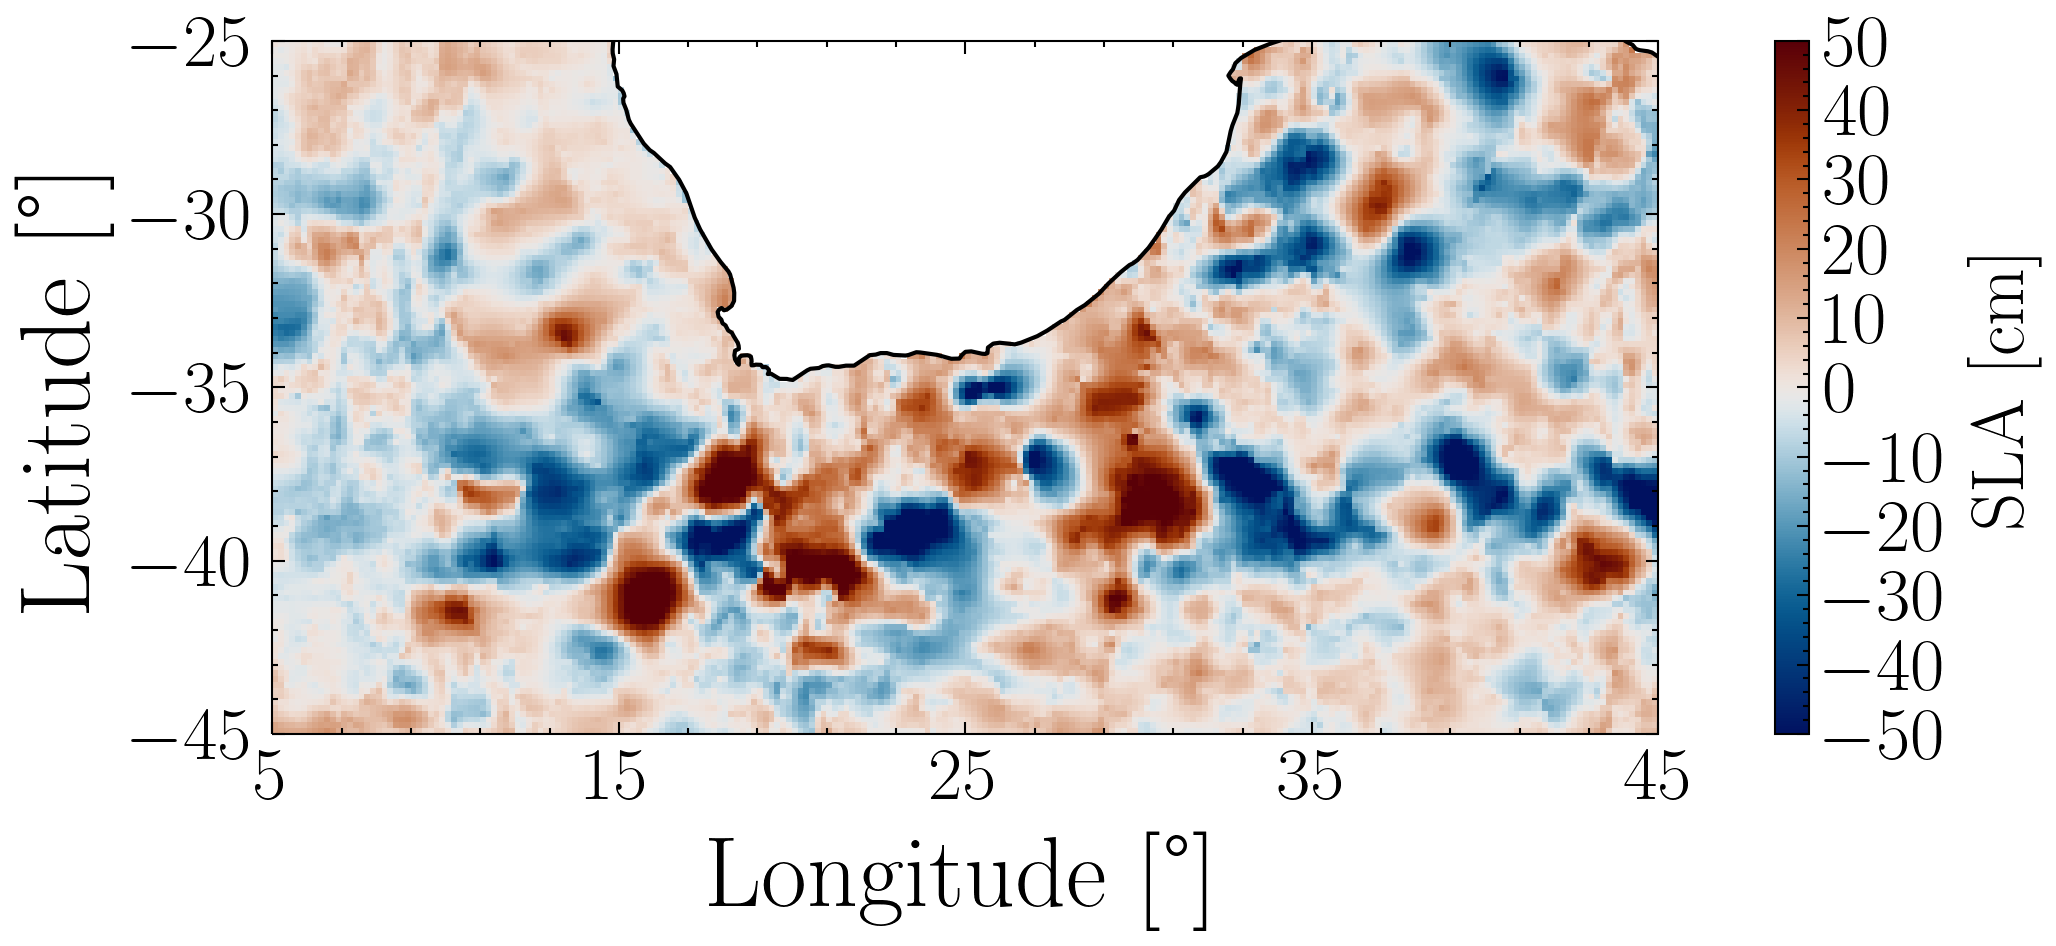

In [8]:
day = np.datetime64(f"2014-09-28T12:00:00.000000000")
# day = np.datetime64(f"2014-09-28T00:00:00.000000000")
# day = np.datetime64(f"2002-07-08T12:00:00.000000000")
# day = np.datetime64(f"2002-08-17T12:00:00.000000000")
extent = [5,45,-45,-25]
lon_idx = (data.Longitude[0] > extent[0]) & (data.Longitude[0] < extent[1])
lat_idx = (data.Latitude[:,0] > extent[2]) & (data.Latitude[:,0] < extent[3])
time_idx = (data.time >= day) & (data.time <= day+np.timedelta64(1))
bad_day = data.sla21.sel(time = time_idx, lons = lon_idx, lats = lat_idx)[0]
vlim = 50

title_size = 20
label_size = 24
tick_size = 18
n_axis_ticks = 5

fig = plt.figure(figsize=(10,3), dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
im=ax.imshow(bad_day*100, extent=extent, origin='lower', vmin=-vlim, vmax=vlim, cmap=cmc.vik)
ax.set_xlabel(f"Longitude [\N{DEGREE SIGN}]", fontsize=label_size)
ax.set_ylabel(f"Latitude [\N{DEGREE SIGN}]", fontsize=label_size)
ax.coastlines()
ax.set_extent(extent)
ax.set_xticks(np.linspace(extent[0],extent[1],n_axis_ticks))
ax.set_yticks(np.linspace(extent[2],extent[3],n_axis_ticks))
ax.tick_params(labelsize=tick_size)
cbar = fig.colorbar(im, ticks=range(-vlim,vlim+10,10))
cbar.set_label("SLA [cm]", fontsize=tick_size)
cbar.ax.tick_params(labelsize=tick_size)
ax.set_ylim([extent[2],extent[3]])
title_day = str(day).split("T")[0]
# ax.set_title(f"South China Sea $1^\circ$ x $1^\circ$\n{title_day}", fontsize=title_size)
plt.show()

In [9]:
day = np.datetime64(f"2014-09-28T00:00:00.000000000")
# extent = [109.875,119.625,4,20]
# extent = [110,120,4,20]
extent = [5,45,-45,-25]

# lon_idx = (data.Longitude[0] > extent[0]) & (data.Longitude[0] < extent[1])
# lat_idx = (data.Latitude[:,0] > extent[2]) & (data.Latitude[:,0] < extent[3])
time_idx = (data.time >= day) & (data.time <= day+np.timedelta64(1))
bad_day = data.sla21.sel(time = time_idx)[0]
# bad_day = data.sla21.sel(time = time_idx, lons = lon_idx, lats = lat_idx)[0]
vlim = 25

title_size = 20
label_size = 13
tick_size = 9
n_axis_ticks = 5

fig = plt.figure(figsize=(10,3), dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
im=ax.imshow(bad_day*100, extent=extent, origin='lower', vmin=-vlim, vmax=vlim, cmap=cmc.vik)
ax.set_xlabel(f"Longitude [\N{DEGREE SIGN}]", fontsize=label_size)
ax.set_ylabel(f"Latitude [\N{DEGREE SIGN}]", fontsize=label_size)
ax.coastlines()
ax.set_extent(extent)
ax.set_xticks(np.linspace(extent[0], extent[1], 5))
ax.set_yticks(np.linspace(extent[2], extent[3], 5))
ax.tick_params(labelsize=tick_size)
cbar = fig.colorbar(im, ticks=range(-vlim,vlim+10,10))
cbar.set_label("SLA [cm]", fontsize=tick_size)
cbar.ax.tick_params(labelsize=tick_size)
ax.set_ylim([extent[2],extent[3]])
title_day = str(day).split("T")[0]
# ax.set_title(f"South China Sea $1^\circ$ x $1^\circ$\n{title_day}", fontsize=title_size)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
sla = data.sla21.sel(time = (data.time < np.datetime64("2005-01-01")) & (data.time > np.datetime64("1996-01-01")))#, lats = (np.abs(data.Latitude[:,0]) < 30))
times = sla.time
freq = np.fft.fftfreq(times.shape[-1], d=1/times.shape[-1])
idx = np.argsort(freq)

ffts = np.zeros(sla.shape, dtype=np.complex64)
for latidx in tqdm(sla.lats.values):
    for lonidx in sla.lons.values:
        cur_fft = np.fft.fft(sla[:, latidx, lonidx])
        ffts[:,latidx,lonidx] = cur_fft[idx]


100%|██████████| 129/129 [00:35<00:00,  3.60it/s]


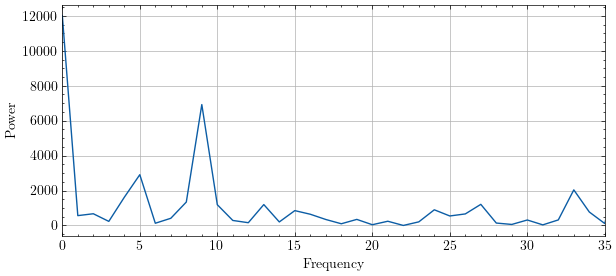

In [ ]:
lat_idx, lon_idx = 0, 150

plt.figure(figsize=(7,3))
plt.plot(freq[idx], abs(ffts[:,lat_idx,lon_idx])**2)
plt.xlim([0,35])
plt.grid()
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.show()

In [ ]:
power = abs(ffts)**2
power_sum = np.nanmax(power, axis=(0))

C:\Users\mathi\AppData\Local\Temp\ipykernel_23744\3466014119.py:2: RuntimeWarning: All-NaN slice encountered
  power_sum = np.nanmax(power, axis=(0))


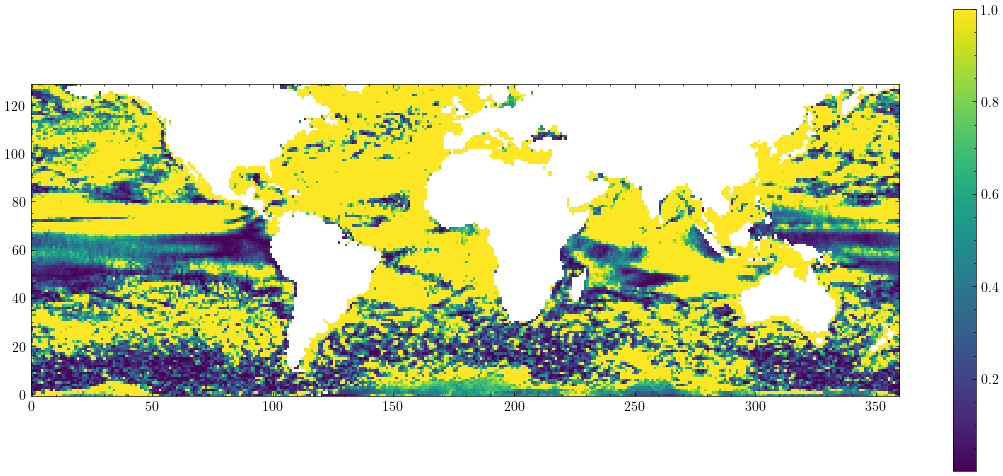

In [ ]:
freq_idx = 9
bool_power = (freq[idx] == freq_idx)
normalized_power = (power[bool_power][0]/power_sum)
plt.figure(figsize=(14,6))
plt.imshow(normalized_power, origin="lower", vmax=1, interpolation="None")
plt.colorbar()
plt.show()

In [ ]:
data["weighted_sla"] = data["sla21"] * np.cos(data["Latitude"]*np.pi/180)
# truncated = data.weighted_sla.sel(time = (data.time < np.datetime64("1994-11-30")) & (data.time > np.datetime64("1994-10-01"))).sel(lats = np.abs(data.Latitude[:,0]) < 30)

In [ ]:
# time_mean_weighted = data.weighted_sla.mean(dim=("lats", "lons"))
time_mean_weighted = truncated.mean(dim=("lats", "lons"))

In [ ]:
sla_fft = np.fft.fft(time_mean_weighted.values)
freq = np.fft.fftfreq(time_mean_weighted.time.values.shape[-1], d=1/time_mean_weighted.time.values.shape[-1])
idx = np.argsort(freq)

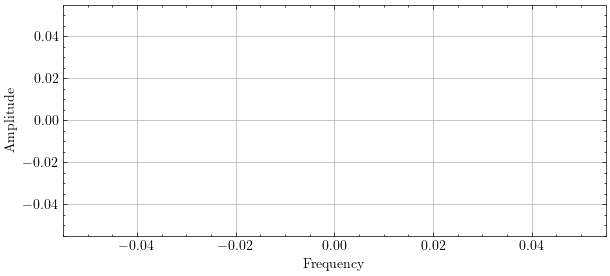

In [ ]:
plt.figure(figsize=(7,3))
plt.plot(freq[idx], sla_fft.real[idx], freq[idx], sla_fft.imag[idx])
# plt.xlim([0,70])
plt.grid()
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

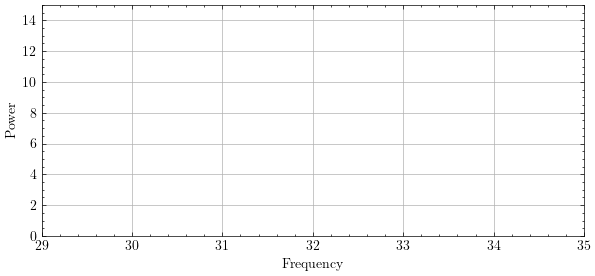

In [ ]:
plt.figure(figsize=(7,3))
plt.plot(freq[idx], abs(sla_fft[idx])**2)
plt.xlim([29,35])
plt.ylim([0,15])
plt.grid()
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.show()

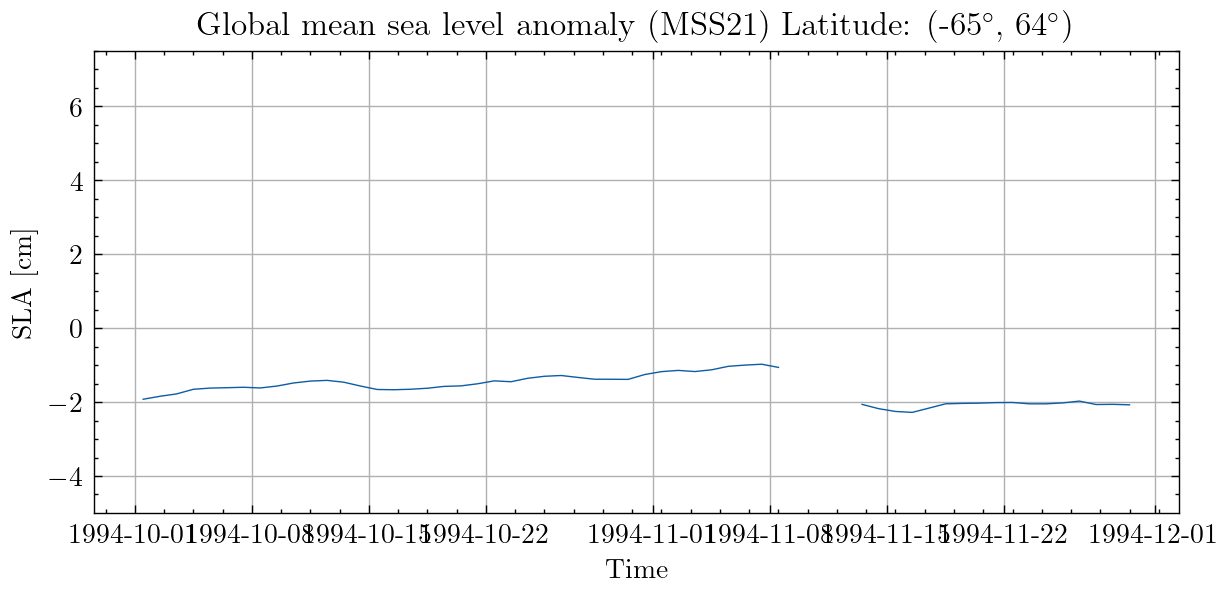

In [ ]:
plt.figure(figsize=(7,3), dpi=200)
plt.plot(truncated.time, time_mean_weighted*100, linewidth=0.5)
plt.ylim([-5, 7.5])
plt.grid()
plt.xlabel("Time")
plt.ylabel("SLA [cm]")
plt.title("Global mean sea level anomaly (MSS21) Latitude: (-65$^\circ$, 64$^\circ$)")
plt.show()

In [ ]:
fit_data = data["weighted_sla"]
X = np.full(fit_data.shape, np.nan)
diffs = np.full(fit_data.shape, np.nan)
for latidx in tqdm(data.lats):
    for lonidx in data.lons:
        x = fit_data[:,latidx, lonidx] * 100
        nan_mask = ~np.isnan(x)
        t = data.time.values.reshape(-1,1)[nan_mask].reshape(-1,1)
        t_lstsq = t.astype("datetime64[D]").astype(np.int32) / 365.25
        T = np.hstack([np.ones(t_lstsq.shape), t_lstsq, np.cos(2*np.pi*t_lstsq), np.sin(2*np.pi*t_lstsq)])
        m = np.linalg.lstsq(T,x[nan_mask], rcond=None)[0]
        X[nan_mask,latidx,lonidx] = T@m
        diffs[nan_mask,latidx,lonidx] = x[nan_mask] - X[nan_mask,latidx,lonidx]

100%|██████████| 129/129 [08:36<00:00,  4.00s/it]


In [ ]:
X_mean = np.nanmean(X, axis=(1,2))
diff_mean = np.nanmean(diffs, axis=(1,2))
x_mean = np.nanmean(fit_data*100, axis=(1,2))

C:\Users\mathi\AppData\Local\Temp\ipykernel_17892\2018481667.py:1: RuntimeWarning: Mean of empty slice
  X_mean = np.nanmean(X, axis=(1,2))
C:\Users\mathi\AppData\Local\Temp\ipykernel_17892\2018481667.py:2: RuntimeWarning: Mean of empty slice
  diff_mean = np.nanmean(diffs, axis=(1,2))
C:\Users\mathi\AppData\Local\Temp\ipykernel_17892\2018481667.py:3: RuntimeWarning: Mean of empty slice
  x_mean = np.nanmean(fit_data*100, axis=(1,2))


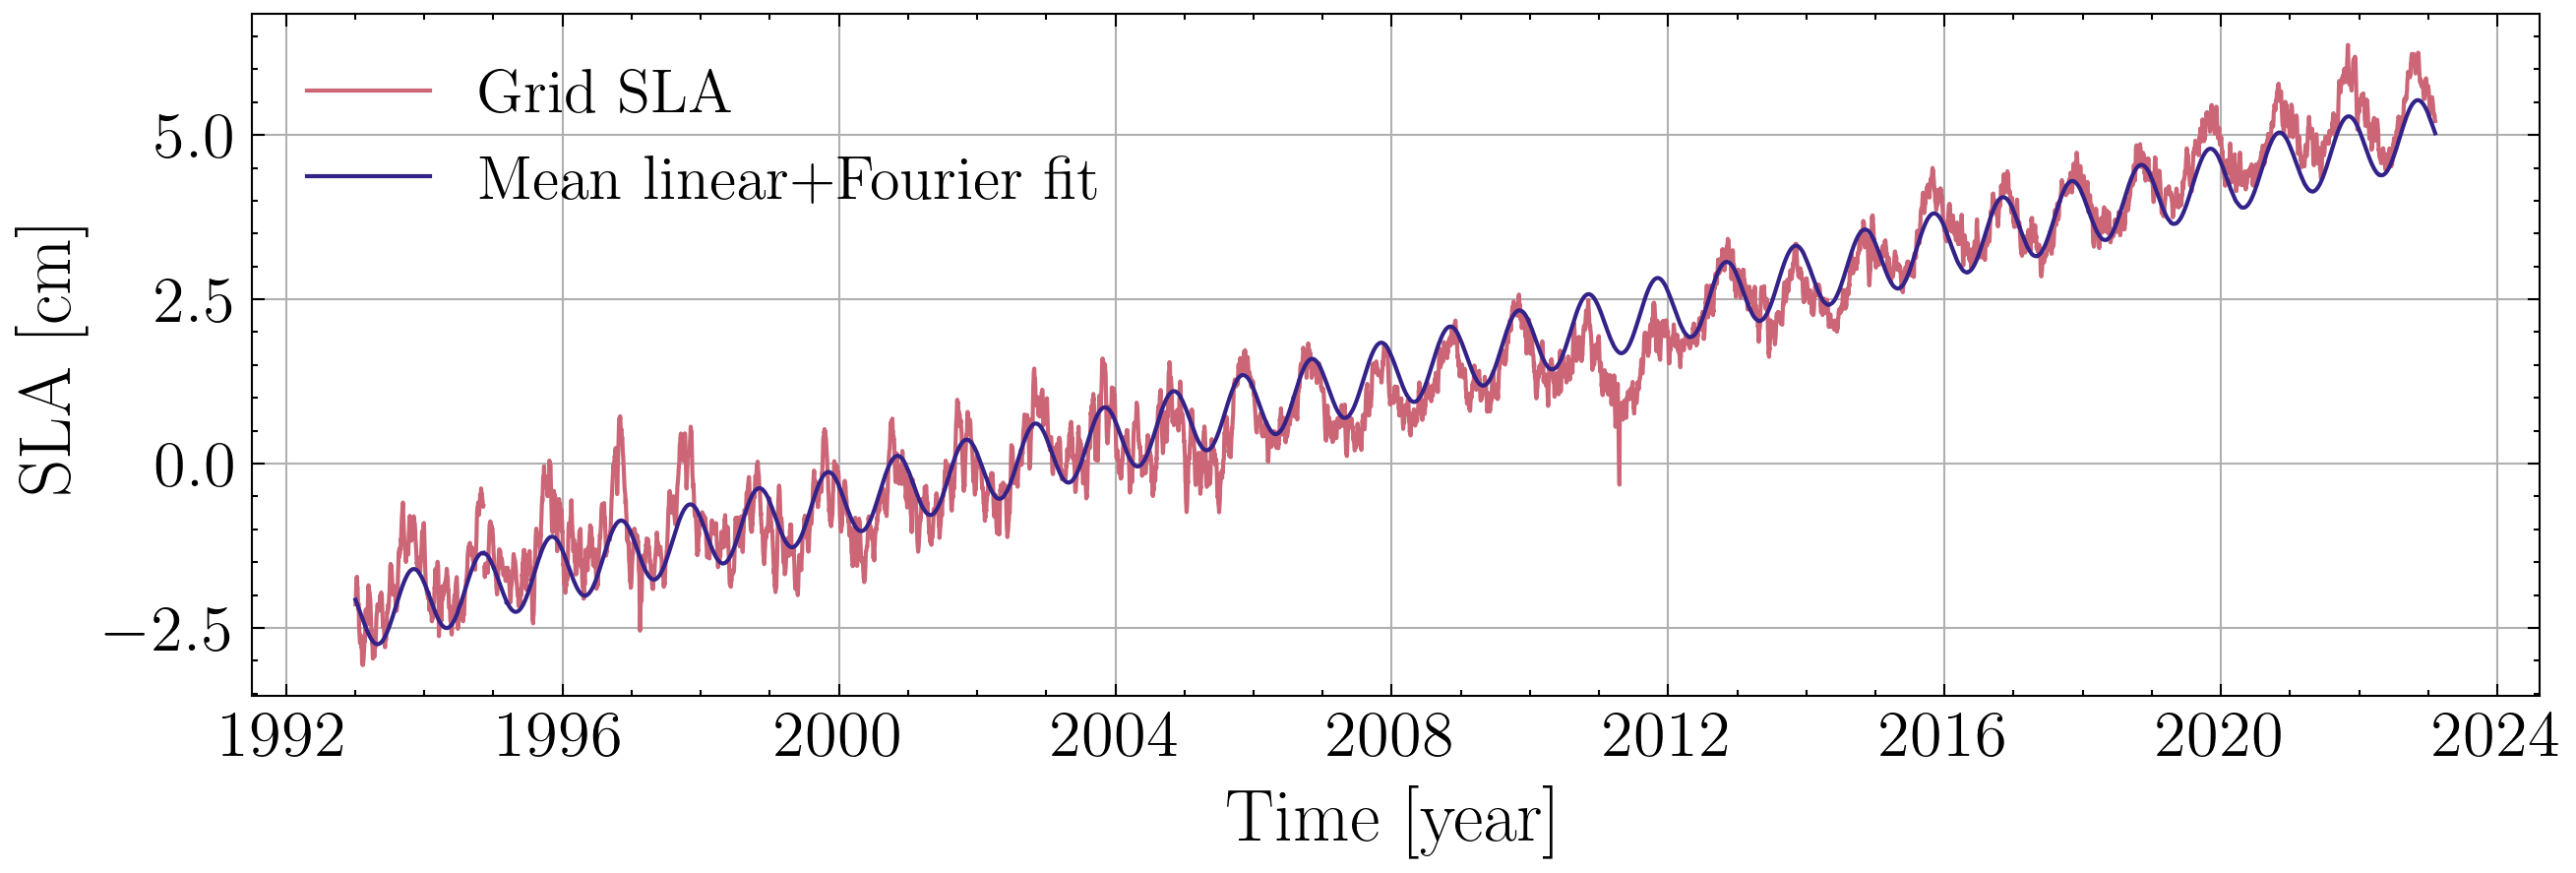

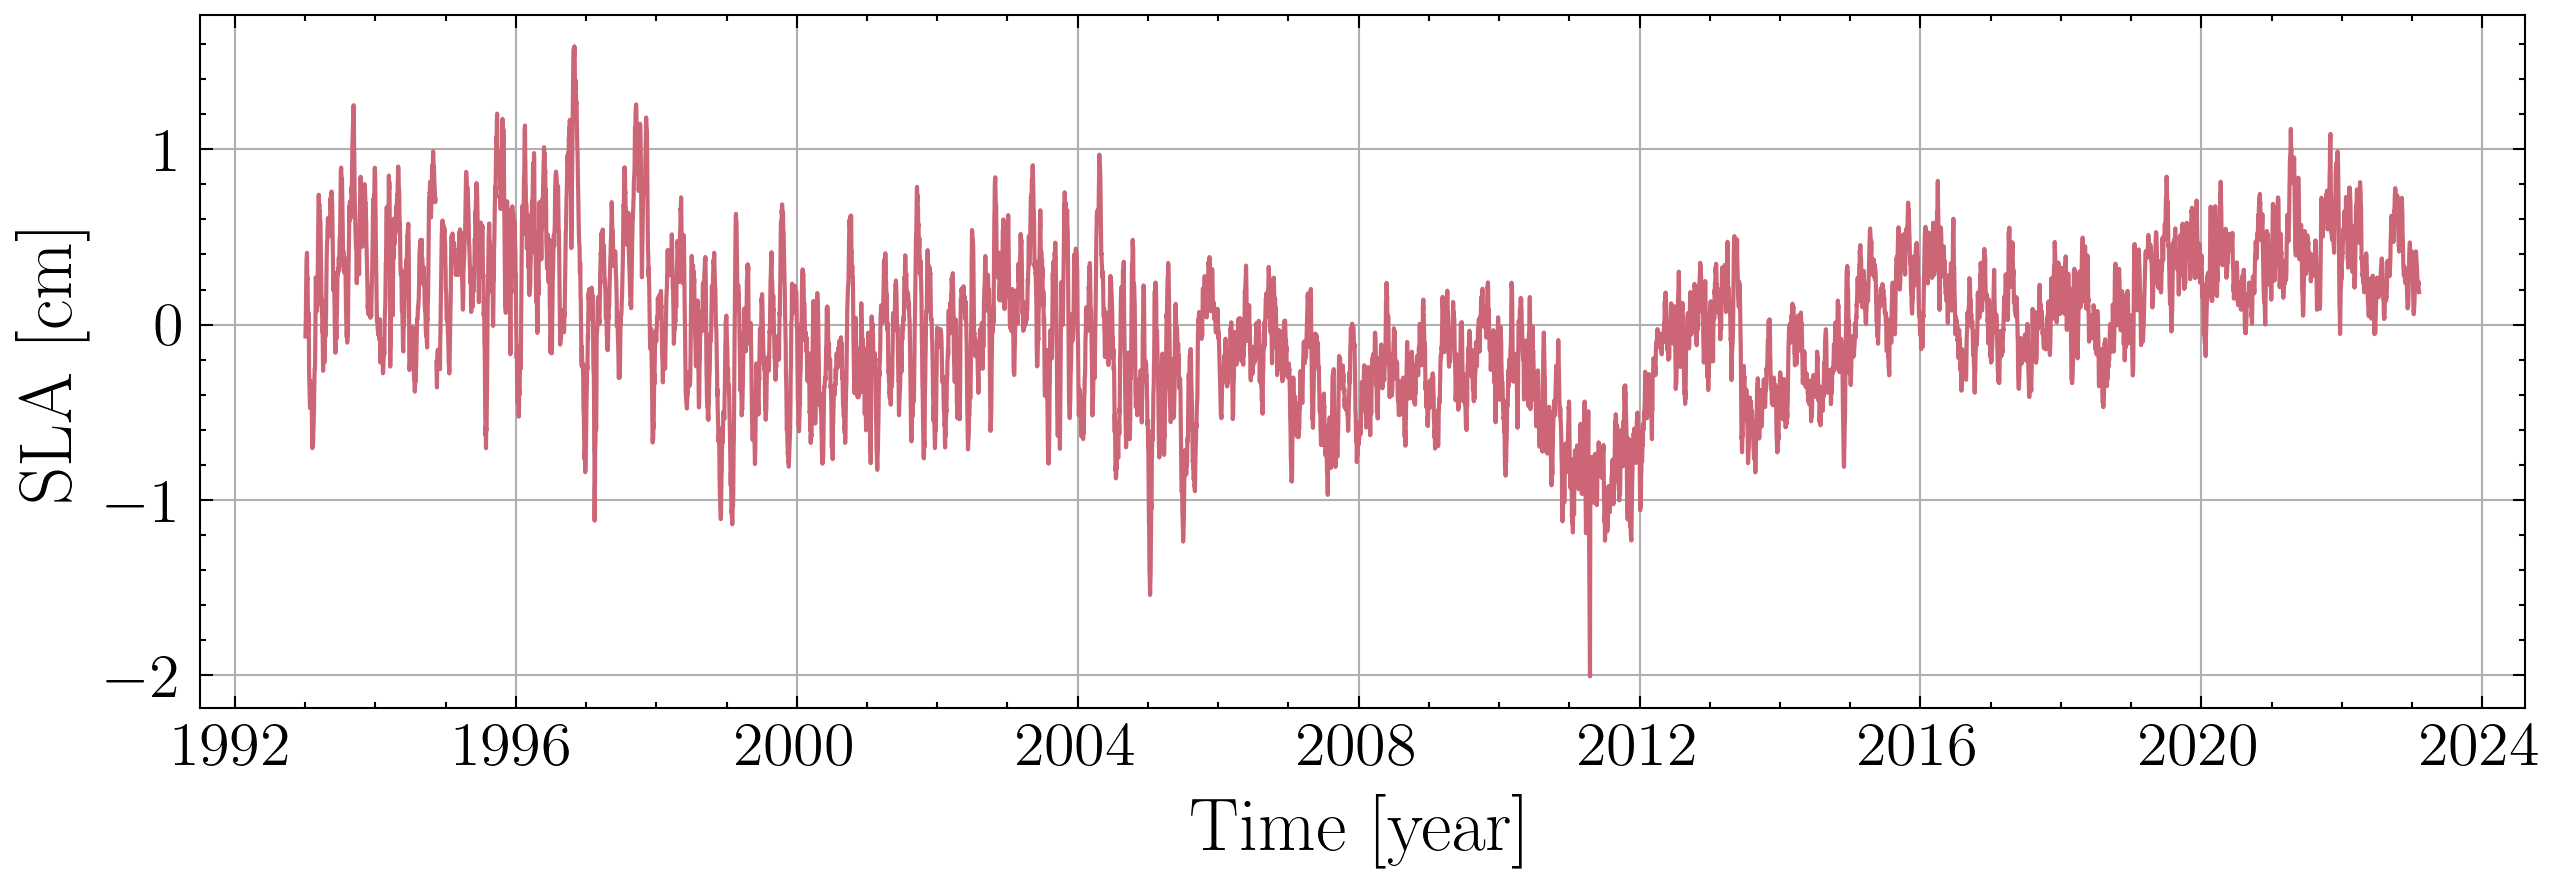

In [ ]:
t_plot = data.time.values

# title_size = 20
label_size = 18
tick_size = 15

plt.figure(figsize=(10,3), dpi=300)
plt.plot(t_plot, x_mean, label="Grid SLA")
plt.plot(t_plot, X_mean, label="Mean linear+Fourier fit")
plt.legend(fontsize=tick_size)
plt.grid()
plt.xlabel("Time [year]", fontsize=label_size)
plt.ylabel("SLA [cm]", fontsize=label_size)
plt.rc('xtick',labelsize=tick_size)
plt.rc('ytick',labelsize=tick_size)
# plt.title("Grid SLA and fit", fontsize=title_size)
plt.show()

plt.figure(figsize=(10,3), dpi=300)
plt.plot(t_plot, diff_mean, label="Difference")
plt.grid()
plt.xlabel("Time [year]", fontsize=label_size)
plt.ylabel("SLA [cm]", fontsize=label_size)
plt.rc('xtick',labelsize=tick_size)
plt.rc('ytick',labelsize=tick_size)
# ax[0].rc('xtick',labelsize=tick_size)
# ax[0].rc('ytick',labelsize=tick_size)
# plt.title("Pixelwise fit corrected grid SLA", fontsize=title_size)
# fig.suptitle("Global mean sea level anomaly (MSS21) Latitude: (-65$^\circ$, 64$^\circ$)",fontsize=title_size)
# plt.tight_layout()
# plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.show()

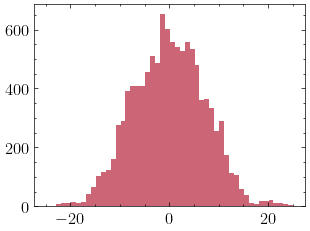

In [ ]:
x = diffs[:,42,23]
x = x[~np.isnan(x)]

plt.hist(x, bins=50)
plt.show()

In [ ]:
def func(x):
    loc, scale = np.mean(x), np.std(x, ddof=1)
    cdf = norm(loc, scale).cdf
    res = ks_1samp(x, cdf)
    return res

In [ ]:
args = []
for i in range(diffs.shape[1]):
    for j in range(diffs.shape[2]):
        args.append(diffs[:,i,j])

with Pool() as p:
    result = [x for x in tqdm(p.imap(func, args), total=len(args))]

100%|██████████| 46440/46440 [01:46<00:00, 434.41it/s] 


In [ ]:
data

<xarray.Dataset>
Dimensions:       (time: 10994, lats: 129, lons: 360)
Coordinates:
    Longitude     (lats, lons) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
    Latitude      (lats, lons) float64 -64.5 -64.5 -64.5 ... 63.5 63.5 63.5
  * time          (time) datetime64[ns] 1993-01-01T12:00:00 ... 2023-02-06T12...
Dimensions without coordinates: lats, lons
Data variables:
    sla           (time, lats, lons) float64 0.005284 0.0668 ... nan 0.3056
    sst           (time, lats, lons) float64 0.5049 0.5351 0.4855 ... nan 1.022
    swh           (time, lats, lons) float64 0.1368 0.2774 0.5097 ... nan 3.286
    wind_speed    (time, lats, lons) float64 5.482 5.488 5.904 ... nan nan 2.925
    sla21         (time, lats, lons) float64 0.005854 0.06027 ... nan 0.3076
    weighted_sla  (time, lats, lons) float64 0.00252 0.02595 ... nan 0.1373
Attributes: (12/13)
    Conventions:           CF-1.7
    title:                 RADS 4 pass file
    institution:           EUMETSAT / NOAA / TU Delft
    source:                radar altimeter
    references:            RADS Data Manual, Version 4.2 or later
    featureType:           trajectory
    ...                    ...
    ellipsoid_axis:        6378136.3
    ellipsoid_flattening:  0.0033528131778969143
    mission_name:          ['TOPEX', 'ERS-2']
    mission_phase:         a
    n_points:              [49039  1065]
    total_points:          50104

In [ ]:
pvalues = np.full(diffs.shape[1:], np.nan)
for i in range(diffs.shape[1]):
    for j in range(diffs.shape[2]):
        x = diffs[:,i,j]
        loc, scale = np.mean(x), np.std(x, ddof=1)
        cdf = norm(loc, scale).cdf
        res = ks_1samp(x, cdf)
        pvalues[i,j] = res.pvalue

# res = goodness_of_fit(norm, x, statistic='ks')

  0%|          | 0/129 [00:00<?, ?it/s]

 15%|█▍        | 19/129 [02:44<15:49,  8.63s/it]


KeyboardInterrupt: 

129